# Incoherent Timing hands-on session - Stingray tutorial

In this tutorial you will learn how to explore a dataset taken from the NICER intrument onboard the ISS. NICER (Neutron star Interior Composition Explorer) is an X-ray telescope that studies accreting neutron stars, black holes, and other variable phenomena, and is characterised by very high (~1$\mu$s) time resolution, which makes it an idea laboratory to study the fast time variability of accreting compact objects. 

---

This notebook is largely based on one of the Stingray tutorial which you can find [here](https://docs.stingray.science/en/latest/notebooks/Spectral%20Timing/Spectral%20Timing%20Exploration.html). 

From the Stingray webpage: **[Stingray](https://zenodo.org/records/13974481) is a Python library designed to perform times series analysis and related tasks on astronomical light curves**. It supports a range of commonly-used Fourier analysis techniques, as well as extensions for analyzing pulsar data, simulating data sets, and statistical modelling. Stingray is designed to be easy to extend, and easy to incorporate into data analysis workflows and pipelines. 

In the past who used to do a-periodic and incoherent timing as part of their research used their own custom software (only very rarely published), which meant that, on the one hand, often enough published results could not be accurately repproduced, and, on the other hand, results from different groups where not always easily comparable. 
A few years ago Stigray was born (largely thanks to Matteo Bachetti, INAF-OAC) and is now becoming the one of the timing software of reference in the field of XRBS, being totally open-source and in constant development.  

I (Sara Motta) published my results using GHATS, an IDL based timing software developed by Tomaso Belloni with contributions of others. While very well-tested, GHATS uses a non open source software (IDL), and therefore this tutorial is written using Stingray instead. GHATS is currently available upon request to me, in case somebody wants to try it out. It will be hosted on a GitHub repository by the beginning of 2026. 

### Contacts: 
Sara E. Motta - INAF Osservatorio Astronomico di Brera

sara.motta@inaf.it

## Basic timing concepts

### Time resolution $\Delta t$ (also _dt_ in the following): 

- **Definition:** this is the sampling interval — the time between consecutive data points in a time series. It sets the **sampling rate:** $f_s = 1/\Delta t$. The maximum time resolution is something intrinsic to the intrument you use to observe a given target. Rebinning a lightcurve means lowering the time resolution. 
- **Implications:** You can’t measure variability faster than about a few $\times \Delta$t .

**Example:** If the time resolution of a time series is $\Delta t = 1/128 s$, then the sampling rate is simply $f_s = 128 Hz$.


### Nyquist frequency $f_{Nyq}$

- **Definition:** this is the highest frequency representable without aliasing for evenly sampled data. In practice, it is the highest frequency you can measure, and also the highest frequency in a power density spectrum, for a given time resolution:

 $$f_{Nyq} = \dfrac{1}{2\Delta t} = \dfrac{f_s}{2}$$  

Any power above $f_{Nyq}$ folds back below $f_{Nyq}$ and contaminates the spectrum.

**Example:** If the time resolution of your data is $\Delta t = 1/128$ s, then $f_{Nyq}$ = 64 Hz.


### Frequency resolution $\Delta f$

- **Definition:** This is the spacing of independent Fourier frequencies, i.e. the **minimum separation** between two narrow features that can be resolved in a Power Density Spectrum.  
The frequency resolution is set by the segment duration: $\Delta f = 1/T$, where $T$ is the **effective** duration of the data segment used in the Fast Fourier Transform. It can be an entire light curve, or just a segment. 

Averaging periodograms (Bartlett's method) lowers the variance of the Powed Density Spectrum, but does not change the frequency resolution, which remains $1/T$.

**Example:** for T=64 s  $\Delta f$ = 1/64 $\approx$ 0.0156 Hz.


---

# 0 - Getting started

In order to run this jupyter notebook you need a working `Python 3`. If you do not already have python on your computer, and easy way to get it is thorugh **[Anaconda](https://www.anaconda.com/)**.
Since this is a jupyter notebook, you obviously also need to install **[Jupyter Lab](https://jupyter.org/)**. 

Finally, you will have to install `Stingray`, via `pip`, `conda`, or from source (I recommend pip). You will find all the instructions [here](https://docs.stingray.science/en/latest/index.html#installation).


## This tutorial

This tutorial is based on two jupyter notebooks:

- **Stingray_tutorial_hands_on**: contains a step-by step example of data exploration and analysis
- **Insights_timing_hands_on**: contains some extra details on certian topics. 

There notebook is organized in a number of steps each dealing with a given topic. \
When you'll see "**> YOUR TURN: ... ... "** it is time for you to get involved and try to manipulate the data.\
When you'll see "**> INSIGHT: ... ... "** you can move to the **"insights_timing_hands_on"** notebook to learn more on a specific topic. 

---


## 1 - Power Spectrum generation

We will use a **NICER observation** taken in 2018 of the **accreting black hole X-ray binary MAXI 1820+070** during its first observed outburst, largely reproducing the results from [De Marco et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...654A..14D/abstract) and [Wang et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...910L...3W/abstract).
The dataset used for the analysis can be downloaded on Zenodo - https://zenodo.org/records/10683101 (2.4 GB).

Please notice that the dataset comes from the NICER archive and was only run through the task `barycorr` to refer the photon arrival times to the solar system barycenter, hence the dataset is _NOT_ science ready. The dataset has not been run through the official NICER pipeline, and some of the features you will see in the power spectrum are instrumental artifacts.
If you want to carry out proper NICER data analysis, please take a look at the [NICER analysis threads](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/). 



In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import black
# Uncomment and run this before releasing a new version of the docs
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=100,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood


First we will produce a light curve. We load the NICER event list into a `stingray.EventList` object, and create a `stingray.Lightcurve` from it (which is also an object). 
For NICER,  and any instruments that uses multiple detectors, it is important to know how many detectors were on during the observation. We will make a quick check, but remember that in some cases, the number of detectors might change during an observation. 
You may plot the `events.det_id` attribute (that gets set thanks to the additional_columns instruction below) and check the header of the event file. 


In [8]:
# We name the dataset 
fname = "ni1200120106_0mpu7_cl_bary.evt.gz"

# Here we load the data, and we also save the information about the detector.
# This will take a while
events = EventList.read(fname, "hea", additional_columns=["DET_ID"])
events.fname = fname

In [9]:
# Print the number of detectors
# events.det_id is a sequence of detector IDs. Set() finds only unique values, len() counts them. 

ndet = len(set(events.det_id))
print(f"NICER was using {ndet} detectors")

NICER was using 52 detectors


One way to check visually how many detectors were on at any time. This is important in case we think the number of detectors might have changed over the time of the observation. 

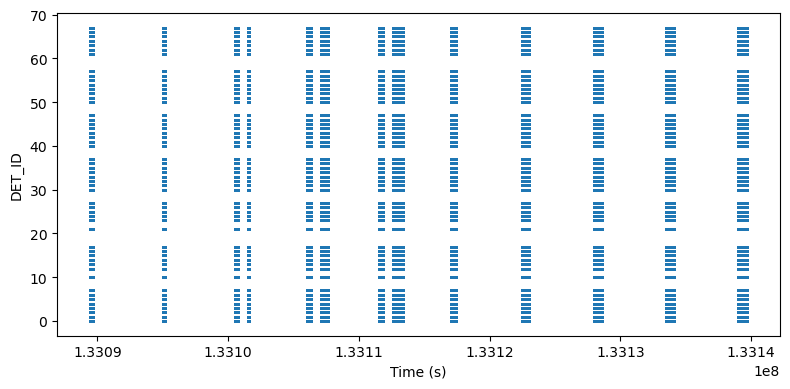

In [11]:
import numpy as np
import matplotlib.pyplot as plt

t = events.time           # seconds from MJDREF (usually) or another ref
y = events.det_id         # detector IDs

plt.figure(figsize=(8,4))
plt.plot(t, y, '.', ms=2, alpha=0.5, rasterized=True)
plt.xlabel('Time (s)')
plt.ylabel('DET_ID')
plt.tight_layout()
plt.show()


Now we create the **light curve**, starting from the events. We use a dedicated function in Stingray. 

<Axes: xlabel='Time (s)', ylabel='counts'>

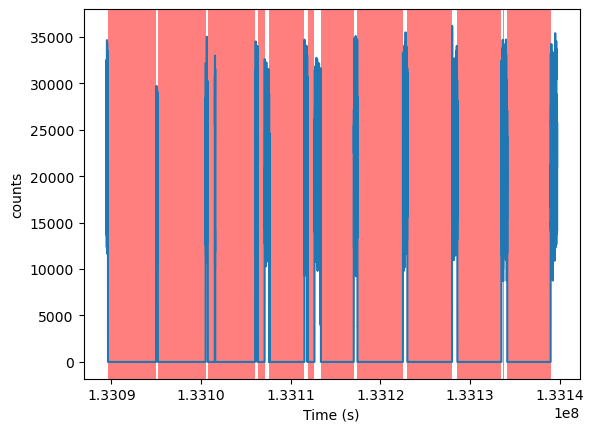

In [13]:
# Now we create light curve and apply GTIs
lc_raw = events.to_lc(dt=1)
lc_raw.plot()

The **blue areas are our data**, the **red areas are the "bad" data**. 
Here the "bad data" are essentially times where there are no data, i.e. NICER was not observing the target. 
You will see that there are "bad data" also in the mistd of the blue "good data". These are small intervals of missing data. We can plot the data around time 1.331126e8. 

<Axes: xlabel='Time (s)', ylabel='counts'>

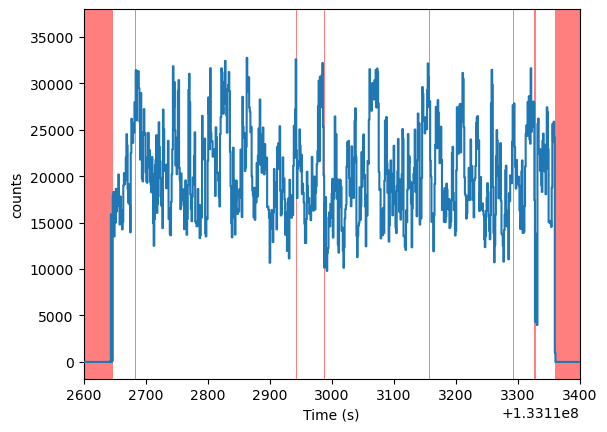

In [15]:
lc_raw.plot(axis_limits=[1.331126e8, 1.331134e8, None, None])

**> YOUR TURN 1: zoom on different data segments to inspect the lightcurvein detail.**

It is important to learn more about these bad data, especially those small bad time intervals (BTIs), which are very annoying when one wants to do some timing analysis. 

**> INSIGHT 1: Why are gaps so annoying when doing timing?**

For instance, we can create an histogram with the lengths of all the gaps in the data. 

Total exposure: 5438.068227797747
Total BTI length: 44846.231474906206
Total BTI length (short BTIs): 33.45650801062584


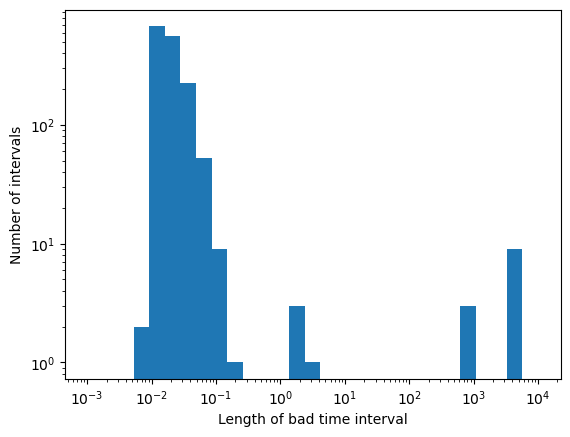

In [19]:
from stingray.gti import get_gti_lengths, get_btis, get_total_gti_length

gti_lengths = get_gti_lengths(events.gti)
btis = get_btis(events.gti)
bti_lengths = get_gti_lengths(btis)

plt.hist(bti_lengths, bins=np.geomspace(1e-3, 10000, 30))
plt.xlabel("Length of bad time interval")
plt.ylabel("Number of intervals")
plt.loglog()

print(f"Total exposure: {get_total_gti_length(events.gti)}")
print(f"Total BTI length: {get_total_gti_length(btis)}")
print(f"Total BTI length (short BTIs): {get_total_gti_length(btis[bti_lengths < 1])}")

There are quite a few very short gaps (less than a second), a few between 1 and 10 seconds, and a few long gaps. These last ones are the intervals between data segments. 
**We want to get rid of the very short data segments**, which are due to small instrumental issues. These short bad intervals are only a very small fraction of the total data (33s out of over 5000), and being much shorter than the data sefments we will be using, they can be filled with simulated data, without altering too much the statistical properties of the data themselves.
Stingray has a function to do that, we only need to decide the maximum lengths of the interval we intend to fill.

In [21]:
## THIS MAY TAKE A LONG TIME.

# max_length is the longest bad time interval in seconds we want to fill with simulated data.
# The buffer size is the region (in seconds) around the bad time interval that we use to
# extract the distribution of the data to simulate
ev_filled = events.fill_bad_time_intervals(max_length=1, buffer_size=10)

lc_filled = ev_filled.to_lc(dt=1)


<Axes: xlabel='Time (s)', ylabel='counts'>

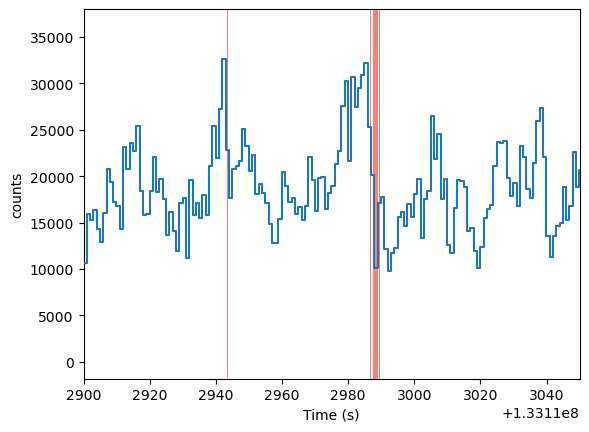

In [22]:
# Here we plot the same data interval we plotted before
lc_raw.plot(axis_limits=[1.331129e8, 1.3311305e8, None, None])

If you want, you can compare the original (raw) light curve with the simulated data in the same interval above, to check if the "correction" we implemented seems reasonable. 

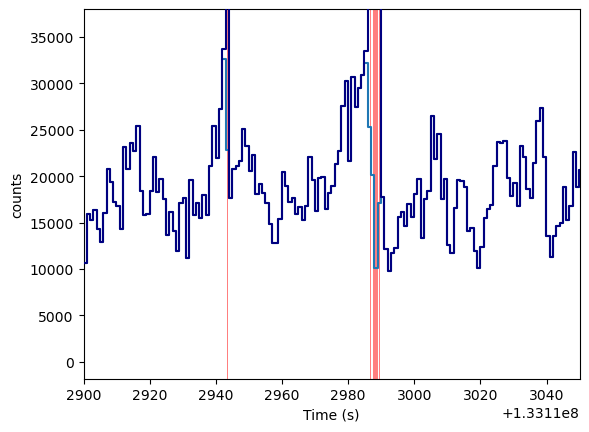

In [25]:
ax = lc_raw.plot(axis_limits=[1.331129e8, 1.3311305e8, None, None])
ax.plot(lc_filled.time, lc_filled.counts, color="Navy", drawstyle="steps-mid", zorder=20)


**> YOUR TURN 2: change the maximum size of the gap and the buffer size and observe what changes**

The light curve seems reasonably clean, with no need for further cleaning. Otherwise, we would have to filter out, e.g. flares or intervals with zero counts, doing something along the lines of:



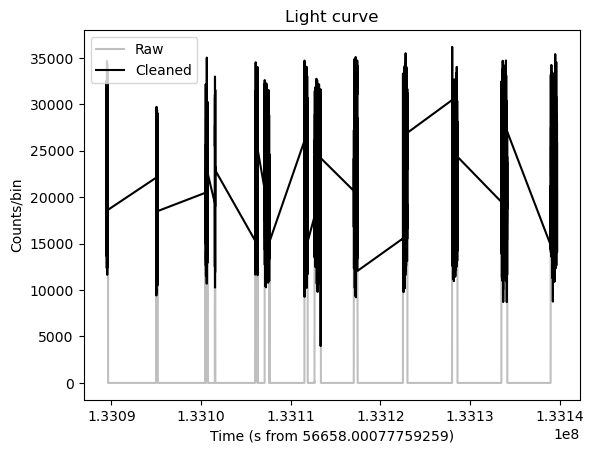

In [28]:
# Looks at the raw light curve and builds Good Time Intervals (GTIs) where the condition counts > 0 is true. 
# Safe_interval=1 shrinks each GTI by 1s at both edges (i.e., it drops 1 s near boundaries to avoid edge effects / partially bad times).

new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=1)
lc = copy.deepcopy(lc_raw)
lc.gti = new_gti
lc.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="grey", alpha=0.5, label="Raw")
plt.plot(lc.time, lc.counts, color="k", label="Cleaned")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")
plt.legend();

events.gti = new_gti


In [29]:
# Lets substitutite the original events with the new, filled, events
events = ev_filled


## Power Density Spectrum and Cross Spectrum


Here is where the real game begins. Now let's take a look at the Power Density Spectrum (PDS) and the Cross Spectrum. 

We will generate the PDS using **Bartlett’s method**: we will split the light-curve into equal-length segments, we will calculate the periodogram for each segment, and then we will average the periodogram into one final periodogram.
This method trades frequency resolution for a (much) lower variance in your power spectrum. 
This relies on the **assumption of stationarity**, i.e. the power density spectrum from each segment is a _different realization of the same intrinsic (i.e., true) power spectral density distribution of the data_. 

**> INSIGHT 2: Bartlett’s method**

We will use the **fractional rms normalization** (sometimes referred to as the **Belloni**, or Miyamoto, normalization, from the papers [Belloni & Hasinger 1990](https://ui.adsabs.harvard.edu/abs/1990A%26A...230..103B/abstract), [Miyamoto et al. 1992](https://ui.adsabs.harvard.edu/abs/1992ApJ...391L..21M/abstract). We will assume that **the background emission is negligible** and hence we will ignore it.

_**Note**: since the fractional rms normalization uses the mean count rate, the final result changes slightly if the normalization is applied in the single periodograms (from each light curve segment, hence using the count rate of each chunk), or on the averaged periodogram (using the average count rate of the full light curve). We choose the second option (note the use_common_mean=True)._



We will first plot the periodogram as is, in units of (rsm/mean)$^2$/Hz.
Then, we will subtract from the periodogram the theoretical Poisson noise level of 2/$\mu$ where $\mu$ is the mean count rate in the observation, and we will multiply the powers by the frequency, to have the periodogram in units of (rsm/mean)$^2$.
In both cases, we will rebin the periodogram geometrically (i.e. logarithmically), averaging more bins together as we move to larger frequencies. This preserves the structure of the spectrum at low frequencies (where the signal to noise ratio is high, and loweres the noise at larger frequencies, where the Poisson noise dominates over the real signal.

In the following example we will rebinn the data to a **time resolution $dt$ of 1ms**. This will give a **Nyquist frequency of 1/2dt = 500Hz**. We will use **segments of length L equal to 256s** each, which will result in a **frequency resolution of 1/L = 0.0039 Hz**. 


In [45]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size = 256
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.5 / dt = 500 Hz.
dt = 0.001
# Fractional rms normalization
norm = "frac"

pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True
)

# Calculate the mean count rate
ctrate = get_average_ctrate(events.time, events.gti, segment_size)

# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

14it [00:00, 27.20it/s]


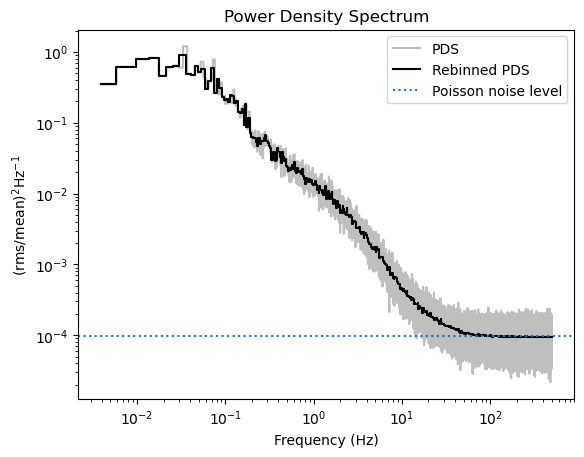

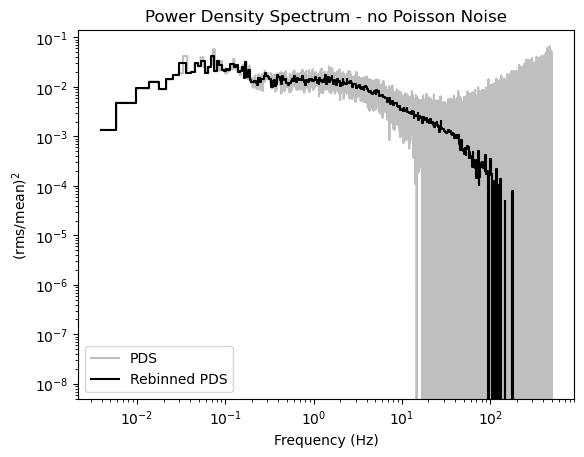

In [46]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.title("Power Density Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.loglog()
plt.title("Power Density Spectrum - no Poisson Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

**> YOUR TURN 3: change bin time resolution and segment size and observe how the PDS changes**

Note that the QPO at ~80 Hz is spurious, and it is due to an instrumental effect. 

And now we will also produce the cross-spectrum between the bands 0.5-1 keV and 1.5-3 keV. In this case, there is no need to subtract the Poisson noise level, as it is zero in the cross spectrum (the Poisson noise in different frequency bins is completely uncorrelated), provided that the energy bands do not overlap, since the Poisson noise is totally uncorrelated.



In [50]:
ref_band = [1.5, 3]
sub_band = [0.5, 1]
events_ref = events.filter_energy_range(ref_band)
events_sub = events.filter_energy_range(sub_band)

cs = AveragedCrossspectrum.from_events(
    events_sub, events_ref, segment_size=segment_size, dt=dt, norm=norm
)
cs_reb = cs.rebin_log(0.02)

14it [00:00, 42.37it/s]
/opt/anaconda3/lib/python3.12/site-packages/stingray/fourier.py:1134: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


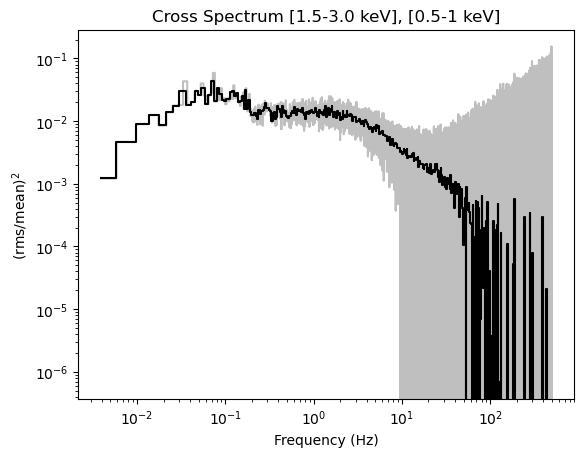

In [51]:
plt.figure()
plt.plot(cs.freq, cs.power * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.loglog()
plt.title("Cross Spectrum [1.5-3.0 keV], [0.5-1 keV]")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");

**> INSIGHT 3: About Power spectra and Cross spectra**

**> YOUR TURN 4: change bin time resolution, segment size and the energy bands, and observe how the cross spectrum changes**

---

## Periodogram modeling

The periodogram of the X-ray emission from an accretion black hole or neutron star is generally a broad distribution of powers extending over a large frequency range, i.e.e from the frequency resolution $\Delta f$, up to the Nyquist frequency $f_{Nyq}$. 
The priodogram is usually modelled with a number of broad components and possibly a few narrow components. 

In [ ]:
pds = AveragedPowerspectrum.from_events(events, segment_size=segment_size, dt=dt, norm="leahy")
pds_reb = pds.rebin_log(0.02)

plt.figure()
plt.semilogx(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)

We will model the periodogram using the maximum likelihood estimation defined in [Barret & Vaughan 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...746..131B/abstract).

For periodograms averaged over $L$ independent segments and $M$ independent neighbouring frequencies, the likelihood is given by:

$$
\mathcal{L}_{\mathrm{avg}}(\theta)
= -\,2ML \sum_{j=1}^{N/2}
\left[
\frac{P_j}{S_j(\theta)}
+ \ln S_j(\theta)
+ \left(\frac{1}{ML}-1\right)\ln P_j
+ c(2ML)
\right].
$$

where 
$\theta$ are the model parameters, 
$P_j$ are the periodogram values, 
$S_j$ the model of the underlying signal, 
c(2ML) is a factor independent of $P_j$ and $S_j$
 or 
, and thus unimportant to the parameter estimation problem considered here (it is basically a normalization factor that scales the likelihood, but does not change its shape).

For **non-uniformly** binned periodograms, like in our case (remember we binned the periodogram logarithmically) the factor $ML$ goes into the sum:

$$
\mathcal{L}_{\mathrm{avg}}(\theta)
= -\,2 \sum_{j=1}^{N/2} M_j L_j
\left[
\frac{P_j}{S_j(\theta)}
+ \ln S_j(\theta)
+ \left(\frac{1}{M_j L_j}-1\right)\ln P_j
+ c\!\left(2 M_j L_j\right)
\right].
$$









Let us create an initial model that roughly describes the periodogram. This will be a combination of Lorentzian shapes, with variable central frequency, width and amplitude. 

**> INSIGHT 4: Why do we use Lorentizains?** 

In [ ]:
## We define the model here. We will start with three components:

fit_model = (
    models.Lorentz1D(x_0=0.02, fwhm=0.15, amplitude=15000)
    + models.Lorentz1D(x_0=0.2, fwhm=3, amplitude=300)
    + models.Lorentz1D(x_0=15, fwhm=30, amplitude=10)
)

# Note that we are roughly substractig the Poisson noise here for display purposes
plt.figure()
plt.plot(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.plot(pds.freq, fit_model(pds.freq) * pds.freq, color="r", label="Starting Model")
for mod in fit_model:
    plt.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend()
plt.ylim([0, None])


We now add a constant at the Poisson noise level (which is by definition a constant = 2 in Leahy normalization) and we will fit the PDS using the Maximum Likelihood estimation in `Stingray`.

In [ ]:
# Data fitting using the Stingray likelihood

from stingray.modeling import PSDParEst

# model is re-defined adding the noise (the constant is the first component now)
fit_model = models.Const1D(amplitude=2) + fit_model

parest = PSDParEst(pds_reb, fitmethod="L-BFGS-B", max_post=False)
loglike = PSDLogLikelihood(pds_reb.freq, pds_reb.power, fit_model, m=pds_reb.m)

# This is where the parameter estimation happens
res = parest.fit(loglike, fit_model.parameters)

# this is the best fit 
fitmod = res.model

# The Poisson noise level is the first parameter.
poisson = fitmod.parameters[0]
print(res.p_opt)

You can check the model parameters for example by printing the attribute `parameters` (and `param_names`) of `fitmod`.

In [ ]:
# Print the best fit parameters

for name, val in zip(fitmod.param_names, fitmod.parameters):
    print(f"{name:>15s} = {val:.6g}")


Finally, we plot the results, with and without the Poisson noise.

In [ ]:
# --- Figure with 3 panels: (1) linear, (2) log-log, (3) residuals ---
plt.figure(figsize=(7, 8))
gs = plt.GridSpec(3, 1, hspace=0, height_ratios=[1.2, 1.2, 0.8])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)

# Plot the fitted PDS in linear-log scale.
ax0.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax0.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax0.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax0.set_xlabel("Frequency (Hz)")
ax0.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax0.legend()

# Subtract the Poisson Noise and then plot. 
ax1.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax1.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax1.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax1.loglog()
ax1.set_ylim([1e-1, None])
ax1.set_xlim([pds.freq[0], pds.freq[-1]]);

# Plot data - models residuals  ---

freq_d   = pds_reb.freq
dataP    = pds_reb.power
modelP   = fitmod(freq_d)              # evaluate best-fit model on rebinned freqs
residP   = dataP - modelP              # Poisson cancels if you subtracted it on both sides

# For consistency with our y-scaling (P * f)
dataPf   = (dataP  - poisson) * freq_d
modelPf  = (modelP - poisson) * freq_d
residPf  = dataPf - modelPf            # residuals in the same units you plotted


# plain residuals 
ax2.axhline(0, color="0.5", lw=1)
ax2.plot(freq_d, residPf, drawstyle="steps-mid", color="k")
ax2.set_ylabel("Residuals")

ax2.set_xlabel("Frequency (Hz)")
ax2.set_xscale("log")  # match your log-x view
ax2.grid(True, which="both", alpha=0.2)

plt.tight_layout()


In [ ]:
# Print the best fit parameters again 

for name, val in zip(fitmod.param_names, fitmod.parameters):
    print(f"{name:>15s} = {val:.6g}")


**> YOUR TURN 5: modify the model to better fit the spectrum**

---

## Lags and coherence


Once we build the cross spectrum, we can explore the both the real part (the equivalent of the power spectrum, but using two energy bands), and the imaginary part (i.e., the phases). We will now explore the time lags as a function of frequency. Remember that we defined the two energy bands above: 0.5-1 keV and 1.5-3 keV.

This time we will use shorter segments for better results (2s), and we will rebin a little more, since lags tend to be more noisy than the powers. 

In [ ]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=2, dt=0.005, norm=norm)
cs_reb = cs.rebin_log(0.4)

lag, lag_e = cs_reb.time_lag()


In [ ]:
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Time lag ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV, in seconds)"
)
plt.axhline(0, ls="--")
plt.semilogx()


**> YOUR TURN 6: modify the time resolution and segment size, and observe how the time-lags change.**

**Some interpretation:** The Time lag spectrum tells by how much the hard emission (1.5-3 keV) lags the soft emission for each frequency, i.e. for each time scale. Here we are reducing the energy information to two bands, and we are unpacking the variability information. In the next section, we will be reducing the frequency information into one single bin, and we will unpack the energy information. 

Physically speaking, the idea here is that the radiation in one band "knows" of the radiation in the other band (and as we will see below, they are largely _coherent_), but there may be some delay between the two lightcurves. Think of the emission coming from an accretion disk: the softer (lower energy) emission comes from the outer regions of the accretion disk. The harder (higher energy) emission comes from the inner regions of the accretion disk. Matter flows from the outside inwards, and it is therefore natural to expect that what happens at larger radii propagates to smaller radii, which somewhat "remember" what happend earlier. 

Then we can inspect the **coherence spectrum**. You can measure it based on the Cross spectrum and is defined as:

$$    \gamma^2(f)=\frac{|\langle X^{\ast}Y\rangle|^2}{\langle |X|^2\rangle\,\langle |Y|^2\rangle}\in[0,1]$$

This is **the fraction of power in x that linearly predicts y at frequency f**. Put more simply, it will give you how much of the emission in band 0 is connected with the emission from band 1. The coherence goes from 0 to 1, so you can see it as the percentage of the emission in band 0 that knows of the emission in band 1.

In [ ]:
coh, coh_e = cs_reb.coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Coherence ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)"
)
plt.axhline(1, ls="--")
plt.loglog()


**Some interpretation:** As mentioned above, this implies that the emission in the two bands we considered is linked. In particular at low frrquencies (longer time-scales) the coherence is very high (almost 1), and decreases for shorter timescales. This is somewhat to be expected, as there is some loss in the longer time-scales variability as the matter flows to smaller radii. 

## Spectral timing

Now let us explore a bit more the spectral timing properties of this observation. 
We will consider both the timing (i.e. variability) properties of the emission, as well as the spectral properties. In practice we will extend what we did by producing the time-lags and coherence spectrum, to explore more the energy information in the data.
We will start with the **lag spectrum** with respect to energy, in different frequency bands. 

Since this may be confusing for who works at differnt wavelenths than X-rays:  “frequency” refers to the frequency of the variability (the inverse of the times-scales), while “energy” refers to the photon energy.

The photons at 0.3-12 keV are modulated by oscillations and other stochastic processes up to ~100 Hz as we have seen from the Power Density Spectrum (see section _Power Density Spectrum and Cross Spectrum_). We will now analyze the spectral timing properties using the variability in a large frequency band (3-30 hz), up to 1 Hz, and between 3 and 30 Hz. The following plot reproduces results from [Kara et al. 2019](https://www.nature.com/articles/s41586-018-0803-x).

In [ ]:
from stingray.varenergyspectrum import CountSpectrum, CovarianceSpectrum, RmsSpectrum, LagSpectrum


energy_spec = np.geomspace(0.5, 10, 41) #-- Makes 41 geometrically spaced numbers from 0.5 to 10
segment_size = 10
bin_time = 0.001
freq_interval = [3, 30]   #-- defines the frequency interval
ref_band = [0.5, 10]      #-- defines the reference band

# Note that if not specified, the reference energy band is the whole band.

lagspec_3_30 = LagSpectrum(
    events,
    freq_interval=freq_interval,
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_3_30.energy

In [ ]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * 1e4,
    yerr=lagspec_3_30.spectrum_error * 1e4,
    fmt="o",
    label="3-30 Hz",
    color="k",
)
plt.title("Lag spectrum, 3-30 Hz")
plt.xlabel("Energy (keV)")
plt.ylabel("Time Lag ($10^{-4}$ s)")
plt.xlim([0.5, 10])
plt.legend()
plt.semilogx()

**Some interpretation:** Here we are calculating the time lag (the delay) between a number of energy bands (the energy bins on the X-axis) with respect to a reference band (we used 0.5-10 keV, so the total energy band). In practice we did the same things we did above to comput the time lags, but we did it unpacking the energy information, and averaging over the frequency information (we are considering the 3-30 Hz frequency band).  

Now let's do the same, but changing the frequency range. We will consider  0.1-1 Hz and we will compare what we obtained before. 

In [ ]:
lagspec_01_1 = LagSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_01_1.energy
energies_err = np.diff(lagspec_01_1.energy_intervals, axis=1).flatten() / 2

In [ ]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Time lag (s)")

The orange points correspond to what we generated earlier. Note that the time lags in the 3-30 Hz frequency band are tiny, while the time lags between the 0.1 to 1 energy bands are much larger. We can better compare them by _converting the time lags into phase lags_. The conversion is done by multiplying the time lag by 2*$\pi$*frequency (remember that frequency is the inverse of period, so multiplying by frequency equals dividing by a period). As frequency we use the mid-frequency of the band we considered.

**> INSIGHTS 5: Time Lags vs Phase Lags (and how to convert)** 

In [ ]:
freq_01_1 = (1 + 0.1) / 2 * 2 * np.pi
freq_3_30 = (3 + 30) / 2 * 2 * np.pi
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum * freq_01_1,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error * freq_01_1,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * freq_3_30,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error * freq_3_30,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Phase lag (rad)")

As you see, the low-frequency variability has much longer time lags than the high-frequency variability, but the phase lags are on the same order of magnitude.

**> YOUR TURN 7: modify the time resolution, the segment size, and the reference band. Observe how the lags change.**

## RMS spectrum

Finally, we can build the **rms spectrum**. The rms spectrum, broadly speaking, tells you how much variability you have at any given energy bin. Since the fractional rms goes from 0 to 1, you can read the rms spectrum as what pecentage of the total variability comes from photons at a given energy band. _Note that the total variability may not be 100%_, and in fact it never is. This is because the rms measures how much of the total emission we consider (here the photons produced bewteen about 0.1 to 12 keV, the NICER bandpass) is varying (normally between less than 1 to 30%, depending on the accretion state of the source). The rms spectrum tells where this variability sits as a function of energy.

In Low-mass XRBs in general the fast variability (anything above ~0.1Hz, or faster that 10 sec) is higher at higher energies. This is because the low energies are dominated by the soft photons from an accretion disc, which is not very variable, and the high energies are more affected by the Comptonised emission from the corona or hot flow. 

Let us build the rms spectrum in two different frequency bands, 0.1-1 Hz, and 3-30 Hz. 

In [ ]:
rmsspec_01_1 = RmsSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)
rmsspec_3_30 = RmsSpectrum(
    events,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)


In [ ]:
plt.figure()

plt.errorbar(
    energies,
    rmsspec_3_30.spectrum,
    xerr=energies_err,
    yerr=rmsspec_3_30.spectrum_error,
    fmt="o",
    label="RMS 3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    rmsspec_01_1.spectrum,
    xerr=energies_err,
    yerr=rmsspec_01_1.spectrum_error,
    fmt="o",
    label="RMS 0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional RMS");

**> YOUR TURN 8: Generate the rms spectrum in different frequency bands and see how its structure changes.**